In [1]:
import re
import csv
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
#import nltk
from collections import Counter 
import matplotlib.pyplot as plt

# On génère les série temporelle

In [2]:
def generate_first_type_time_series(nb_series, size):
    return np.array([[np.sin(np.divide(2*np.pi*i*t, 64)) for t in range(size)] for i in range(1,nb_series+1)])

In [3]:
def generate_second_type_time_series(nb_series, size):
    fst_type = generate_first_type_time_series(nb_series, size)
    result = []
    frac = 1/(nb_series-1)
    for i in range(1,nb_series+1):
        loc = []
        for t in range(1,size+1):
            fst = fst_type[i-1,t-1]
            snd=frac*np.sum(np.delete(fst_type[:,t-1], i-1, axis=0))
            loc.append(fst+snd)
        result.append(loc)
    return np.array(result)

In [4]:
fst_series = generate_first_type_time_series(6,64)
snd_series = generate_second_type_time_series(6,64)

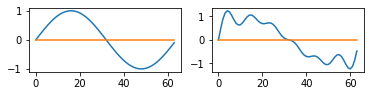

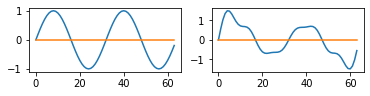

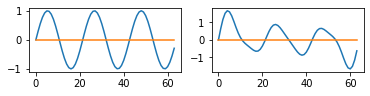

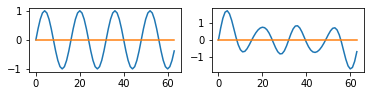

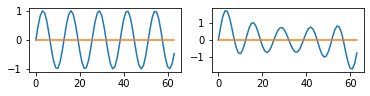

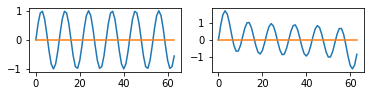

In [5]:
for s1,s2 in zip(fst_series, snd_series):
    plt.subplot(321)
    plt.plot(s1)
    plt.plot([0 for i in range(64)])
    plt.subplot(322)
    plt.plot(s2)
    plt.plot([0 for i in range(64)])
    plt.show()

In [174]:
class GRU_forecaster(nn.Module):
    def __init__(self, nb_cells, hidden_size, input_size, rnn_dropout, window_size, bidirectional=False):
        super(GRU_forecaster, self).__init__()
        
        self.nb_cells = nb_cells
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.is_bidirectional = bidirectional
        
        self.gru = nn.GRU(input_size, hidden_size, nb_cells, batch_first = True, dropout=rnn_dropout,bidirectional=bidirectional)

        if bidirectional:    
            self.fc = nn.Linear(2*hidden_size, 1)
        else:
            self.fc = nn.Linear(hidden_size, 1)
        
        ###Par rapport au papier, k=nbr de filtres et m=hidden size
        self.convList = nn.ModuleList([nn.Conv1d(1,1,window_size-1) for i in range(32)])#32 fixed in the paper

        self.fc1_attn = nn.Linear(hidden_size, 20)#Wa
        
        self.sigmoid = nn.Sigmoid()
        
        nn.init.xavier_uniform_(self.fc.weight.data)  # Xavier/Glorot init for tanh
        nn.init.zeros_(self.fc.bias.data)  # Xavier/Glorot init for tanh
        
            
    
    def forward(self, inputs, h0):
        batch_size = inputs.size(0)
        rnn_out, _ = self.gru(inputs, h0)
        hidden = rnn_out.transpose(1,2)[:,:,:-1]
        last_h = rnn_out[0,-1]
        hc = th.Tensor() #size m*k
        #l_out = self.getNbFeatures()
        
        for conv in self.convList:
            t = th.Tensor()
            for h in hidden[0]:
                h=h.view(1,1,-1)
                x = conv(h)
                t=th.cat([t,x],0)
            t = t.view(-1,1)
            hc=th.cat([hc,t],1)
        hc_t = hc.transpose(1,0) 
        print("hc_t :", hc_t.shape)
        print("hc :", hc.shape)
        
        
        attention_weights = self.fc1_attn(last_h).view(-1,1) #Wa @ Ht
        print("attention_weights 1",attention_weights.shape)
        attention_weights = (hc_t@attention_weights)#.view(1,-1)
        print("attention_weights 2",attention_weights.shape)
        attention_weights = self.sigmoid(attention_weights)
        print("attention_weights 3",attention_weights.shape)
        
        vt = (attention_weights*hc).sum(dim=0) #ai * Hci
        #print(vt.shape)
        
        return rnn_out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        #hidden = th.Tensor(self.nb_cells, batch_size, self.hidden_size)
        if self.is_bidirectional:
            hidden = weight.new(2*self.nb_cells, batch_size, self.hidden_size).zero_()
        else:
            hidden = weight.new(self.nb_cells, batch_size, self.hidden_size).zero_()
        return hidden
    

In [175]:
nb_cells=1
hidden_size=20
input_size=1
gru=GRU_forecaster(nb_cells,hidden_size, input_size, 0.0,64)
h0 = gru.init_hidden(1)

In [176]:
x = th.from_numpy(fst_series[0]).view(1,-1,1).float()
h0=th
#print(x.shape)
gru(x, None)

hc_t : torch.Size([32, 20])
hc : torch.Size([20, 32])
attention_weights 1 torch.Size([20, 1])
attention_weights 2 torch.Size([32, 1])
attention_weights 3 torch.Size([32, 1])


RuntimeError: The size of tensor a (32) must match the size of tensor b (20) at non-singleton dimension 0

# test de trucs

In [51]:
convList = nn.ModuleList([nn.Conv1d(1,1,4) for i in range(19)])
gru = nn.GRU(1,20,1)
x = th.rand(1,64,1)
y_t,h=gru(x)

In [72]:
tensor = th.rand(1,19,64)
print(y_t.shape)
print(h.shape)

torch.Size([1, 64, 20])
torch.Size([1, 64, 20])


In [192]:
s = []
i=0
z = th.Tensor()
for conv, t in zip(convList, y_t[0,:-1,]):
    print(i)
    i+=1
    t = t.view(1,1,-1)
    x=conv(t).view(17,-1)
    print(x.shape)
    z=th.cat([z,x],1)

0
torch.Size([17, 1])
1
torch.Size([17, 1])
2
torch.Size([17, 1])
3
torch.Size([17, 1])
4
torch.Size([17, 1])
5
torch.Size([17, 1])
6
torch.Size([17, 1])
7
torch.Size([17, 1])
8
torch.Size([17, 1])
9
torch.Size([17, 1])
10
torch.Size([17, 1])
11
torch.Size([17, 1])
12
torch.Size([17, 1])
13
torch.Size([17, 1])
14
torch.Size([17, 1])
15
torch.Size([17, 1])
16
torch.Size([17, 1])
17
torch.Size([17, 1])
18
torch.Size([17, 1])


In [193]:
z.shape

torch.Size([17, 19])

In [203]:
x = th.arange(10).view(10,-1)
y=th.arange(10,20).view(10,-1)
print(x,y)

tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]]) tensor([[10],
        [11],
        [12],
        [13],
        [14],
        [15],
        [16],
        [17],
        [18],
        [19]])


In [191]:
z=th.cat([x,y],1)
print(z)
print(z.shape)

tensor([[ 0, 10],
        [ 1, 11],
        [ 2, 12],
        [ 3, 13],
        [ 4, 14],
        [ 5, 15],
        [ 6, 16],
        [ 7, 17],
        [ 8, 18],
        [ 9, 19]])
torch.Size([10, 2])


In [198]:
print(convList[0].padding)

(0,)


In [160]:
f = th.rand(19,17)
f2 = th.rand(17,1)

In [161]:
print(f@f2)

tensor([[4.6065],
        [3.9645],
        [3.9892],
        [3.7921],
        [3.8814],
        [4.7729],
        [3.7582],
        [3.8807],
        [4.3257],
        [4.3800],
        [3.7940],
        [3.6527],
        [3.4391],
        [5.0214],
        [4.7301],
        [4.6858],
        [4.4893],
        [4.5757],
        [5.3400]])


In [48]:
c = nn.Conv1d(1,1,63)
t = th.rand(20,63)

In [52]:
for ti in t:
    
    ti=ti.view(1,1,-1)
    
    print(convList(ti).shape)

NotImplementedError: 

In [54]:
for i, c in enumerate(convList):
    print(i, c)

0 Conv1d(1, 1, kernel_size=(4,), stride=(1,))
1 Conv1d(1, 1, kernel_size=(4,), stride=(1,))
2 Conv1d(1, 1, kernel_size=(4,), stride=(1,))
3 Conv1d(1, 1, kernel_size=(4,), stride=(1,))
4 Conv1d(1, 1, kernel_size=(4,), stride=(1,))
5 Conv1d(1, 1, kernel_size=(4,), stride=(1,))
6 Conv1d(1, 1, kernel_size=(4,), stride=(1,))
7 Conv1d(1, 1, kernel_size=(4,), stride=(1,))
8 Conv1d(1, 1, kernel_size=(4,), stride=(1,))
9 Conv1d(1, 1, kernel_size=(4,), stride=(1,))
10 Conv1d(1, 1, kernel_size=(4,), stride=(1,))
11 Conv1d(1, 1, kernel_size=(4,), stride=(1,))
12 Conv1d(1, 1, kernel_size=(4,), stride=(1,))
13 Conv1d(1, 1, kernel_size=(4,), stride=(1,))
14 Conv1d(1, 1, kernel_size=(4,), stride=(1,))
15 Conv1d(1, 1, kernel_size=(4,), stride=(1,))
16 Conv1d(1, 1, kernel_size=(4,), stride=(1,))
17 Conv1d(1, 1, kernel_size=(4,), stride=(1,))
18 Conv1d(1, 1, kernel_size=(4,), stride=(1,))
